# Purchase History and Market Basket Analysis

Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use!

This is what they asked you to do:

- The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:
 - the customer who bought the most items overall in her lifetime
 - for each item, the customer who bought that product the most
- Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

While not requested, we'll also demonstrate basic market basket analysis and see how the rules it derives can be used to craft sales or recommendations to our users.

# Index
1. [Initial Exploration](#explore)
2. [Top Customers](#topcustomers)
    1. [Overall](#overall)
    2. [Each Item](#eachitem)
3. [Clustering Products](#cluster)
    1. [K-Means](#kmeans)
    2. [Correlation](#correlation)
4. [Market Basket Analysis](#mba)
5. [Conclusions](#conclusions)

<a name='explore'></a>
# Initial Exploration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
item_ids = pd.read_csv('PRIVATE CSV')
print(item_ids.shape)
item_ids.head()

(48, 2)


,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [ ]:
purchases = pd.read_csv('PRIVATE CSV')
print(purchases.shape)
purchases.head()

(39474, 2)


,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


We need to split the item ID's into individual columns, then rename them to their item names, and combine the purchase history of individual users.

In [ ]:
onehots = purchases['id'].str.split('\s*,\s*',
                            expand=True).stack().str.get_dummies().sum(level=0)
purchases = purchases.drop('id', axis='columns').merge(onehots, 
                                            left_index=True, right_index=True)

In [ ]:
item_map = {str(key): value for key, value in 
            item_ids.set_index('Item_id').to_dict()['Item_name'].items()}
purchases = purchases.rename(item_map, axis='columns').set_index('user_id')
purchases = purchases.groupby('user_id').sum()

In [ ]:
purchases.head()

,sugar,carrots,cereals,shampoo,bagels,eggs,aluminum foil,milk,beef,laundry detergent,shaving cream,lettuce,grapefruit,cheeses,frozen vegetables,tea,paper towels,cherries,spaghetti sauce,dishwashing,canned vegetables,hand soap,pet items,flour,pasta,apples,toilet paper,tortillas,soap,ice cream,dinner rolls,juice,sandwich loaves,baby items,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt,waffles,poultry,sandwich bags,butter,soda
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0
68,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
113,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
123,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


The most common item by far is lettuce and the least common is flour. The items on the low end are likely going to be the hardest to group. Lettuce being so prevalent may also be a problem simply due to being in so many baskets (nearly 60%).

In [ ]:
purchases.mean().sort_values(ascending=False).head()

lettuce      0.581595
sugar        0.366446
cucumbers    0.363673
cherries     0.362427
apples       0.361985
dtype: float64

In [ ]:
purchases.mean().sort_values(ascending=False).tail()

baby items    0.131083
waffles       0.113201
pasta         0.109745
cereals       0.109705
flour         0.105726
dtype: float64

<a name='topcustomers'></a>
# Top Customers

<a name='overall'></a>
To get the customer who purchased the most items we simply need to sum all of the counts and sort in descending order.

We see that customer 269335 has purchased the most items with 72.

In [ ]:
purchases.T.sum().sort_values(ascending=False).reset_index().rename({0:'count'},
                                                             axis='columns')[:1]

,user_id,count
0,269335,72


<a name='eachitem'></a>
Gettting the customer who purchased each item the most is a simple call to `idxmax` which gives us the first occurence of the maximum value over the defined axis.

In [ ]:
pd.DataFrame(purchases.idxmax().T).rename({0:'customer'}, axis='columns')

,customer
sugar,31625
carrots,618914
cereals,367872
shampoo,557904
bagels,653800
eggs,172120
aluminum foil,143741
milk,73071
beef,366155
laundry detergent,917199


<a name='clustering'></a>
# Clustering Products

<a name='kmeans'></a>
K-Means clustering is going to be where we start, allowing us to easily find groupings of products.

We'll start by creating an item similarity matrix and then use that to determine how many groupings is optimal with an elbow and silhoutte plot.

In [ ]:
normed_purchases = normalize(purchases.values, axis=0)
item_similarity = normed_purchases.T.dot(normed_purchases)
item_similarity = pd.DataFrame(item_similarity, index=purchases.columns,
                               columns=purchases.columns)

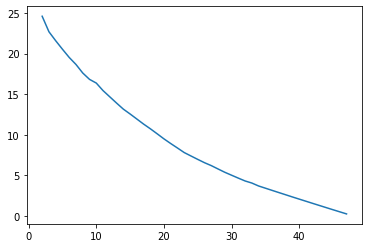

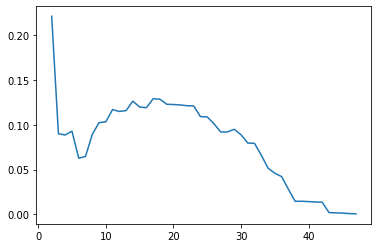

In [ ]:
clusters = range(2, 48)
elbow = []
silhouette = []

for n in clusters:
    kmeans = KMeans(n_clusters=n, random_state=13, n_jobs=-1)
    kmeans = kmeans.fit(item_similarity.T)
    label = kmeans.predict(item_similarity.T)
    
    elbow.append(kmeans.inertia_)
    silhouette.append(silhouette_score(item_similarity.T, label))

plt.plot(clusters, elbow)
plt.show()
plt.plot(clusters, silhouette)
plt.show()

There doesn't seem to be a clear point on either graph for optimal number of clusters. I tested multiple points and found 13 or 14 clusters to be the best based on the what items are in each group.

The resulting groups are pretty solid, not much needs to be moved around besides `pet_items`.

In [ ]:
GROUPS = 14

kmeans = KMeans(n_clusters=GROUPS, random_state=13, n_jobs=-1)
kmeans = kmeans.fit(item_similarity.T)
label = kmeans.predict(item_similarity.T)

df = pd.DataFrame({'Item Name': purchases.columns, 'Group': label})
group_sets = {}
for i in range(GROUPS):
    group_sets[i] = list(df[df['Group'] == i]['Item Name'])

Now that we have the groups, we can pull out the most popular categories. Vegetables and Fruits take the top two spots, which makes sense since they have the largest item sets, are generally staple ingredients in many dishes, and have a low price point. We can also see our weakest categories, surprisingly cereal is at the bottom. Based on the fact that this is a grocery store, cereal being so low seems abnormal and something the products team might want to dig into further.

In [ ]:
def find_item_set(group):
    return group_sets[group]

In [ ]:
item_counts = pd.DataFrame(purchases.sum()).reset_index()
item_counts.columns = ['Item Name', 'Count']

df = df.merge(item_counts)
group_counts = df.groupby('Group').sum().sort_values('Count', ascending=False).reset_index()
group_counts['items_in_set'] = group_counts['Group'].apply(find_item_set)

group_counts

,Group,Count,items_in_set
0,7,50264,"[carrots, lettuce, cucumbers, broccoli, caulif..."
1,6,44777,"[grapefruit, cherries, apples, berries, bananas]"
2,0,44256,"[sugar, tea, juice, coffee, soda]"
3,4,34900,"[bagels, tortillas, dinner rolls, sandwich loa..."
4,8,33243,"[beef, pet items, pork, poultry]"
5,2,28538,"[eggs, milk, cheeses, yogurt, butter]"
6,10,19234,"[spaghetti sauce, canned vegetables, ketchup]"
7,5,13254,"[shampoo, shaving cream, hand soap, soap]"
8,1,13224,"[aluminum foil, paper towels, toilet paper, sa..."
9,13,12115,"[laundry detergent, dishwashing ]"




---


<a name='correlation'></a>
This section was created when before I tweaked k-means for better results; I'm leaving it in to demonstrate a different method.

The core of the method below is to group items by their correlation coeffecient. The higher the correlation the more likely the items are to show up together. The other portion of this method is to make sure each item is in only one group, something we can correct with the use of `set` and `frozenset`.

In [ ]:
def create_groups(items, df):
    # Create groups based off item correlations ordered high to low
    groups = dict()
    cats = set()

    for col in items:
        # groups[col] = set(df.corr()[col].sort_values(ascending=False)[0:5].index)
        groups[col] = set(df[col].sort_values(ascending=False)[:5].index)

    for col in items:
        for col2 in items:
            if (groups[col] == groups[col2]) and (col != col2):
                cats.add(frozenset(groups[col]))
    
    return cats

In [ ]:
def filter_groups(groups):
    # Cycle through the created groups and remove dupes, output the clean groups
    # and the miscellaneous items that are groupless
    unique_groups = set()
    items = []

    for group in groups:
        temp = set(group)
        for group2 in groups:
            if group != group2:
                temp.difference_update(set(group2))
        unique_groups.add(frozenset(temp))
        items += list(temp)

    return unique_groups, items

We'll perform two passes with the above functions. The first pass generates 12 ungrouped items. One of the main drawbacks of our k-means groups is a large catch-all group and a lot of single item groups so we want to find a better way to deal with those 12 items. The solution is to do another pass through the two functions. We still end up with some miscellaneous items but overall we end up with better groupings. At this point, you could do some manual corrections of some of the items/groups but overall the groups are fairly coherent.

In [ ]:
unique_groups, items = filter_groups(create_groups(purchases.columns, purchases))
misc = list(set(purchases.columns).difference(set(items)))

misc_groups, items2 = filter_groups(create_groups(misc, purchases[misc]))
misc = list(set(purchases.columns).difference(set(items + items2)))

for group in misc_groups:
    unique_groups.add(group)
unique_groups.add(frozenset(misc))

unique_groups

{frozenset({'aluminum foil',
            'apples',
            'baby items',
            'bagels',
            'bananas',
            'beef',
            'berries',
            'broccoli',
            'butter',
            'canned vegetables',
            'carrots',
            'cauliflower',
            'cereals',
            'cheeses',
            'cherries',
            'coffee',
            'cucumbers',
            'dinner rolls',
            'dishwashing\xa0',
            'eggs',
            'flour',
            'frozen vegetables',
            'grapefruit',
            'hand soap',
            'ice cream',
            'juice',
            'ketchup',
            'laundry detergent',
            'lettuce',
            'milk',
            'paper towels',
            'pasta',
            'pet items',
            'pork',
            'poultry',
            'sandwich bags',
            'sandwich loaves',
            'shampoo',
            'shaving cream',
            'soap',
           

<a name='mba'></a>
# Market Basket Analysis

Although the prompt did not require it, the dataset seems ripe for association analysis and would be useful for a focus group, especially if there are some unintuitive associations.

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    else:
        return 1

encoded_purchases = purchases.applymap(encode_units)

encoded_purchases.head()

,sugar,carrots,cereals,shampoo,bagels,eggs,aluminum foil,milk,beef,laundry detergent,shaving cream,lettuce,grapefruit,cheeses,frozen vegetables,tea,paper towels,cherries,spaghetti sauce,dishwashing,canned vegetables,hand soap,pet items,flour,pasta,apples,toilet paper,tortillas,soap,ice cream,dinner rolls,juice,sandwich loaves,baby items,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt,waffles,poultry,sandwich bags,butter,soda
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0
68,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
113,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
123,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [ ]:
# Use apriori to get our rulesets
frequent_itemsets = apriori(encoded_purchases, min_support=0.05,
                            use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.25)

# Add features so we can filter on number of items in a rule
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequent_len"] = rules["consequents"].apply(lambda x: len(x))

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(shampoo),(sugar),0.126100,0.327346,0.052160,0.413639,1.263616,0.010882,1.147168,1,1
1,(sugar),(shampoo),0.327346,0.126100,0.052160,0.159342,1.263616,0.010882,1.039543,1,1
2,(sugar),(eggs),0.327346,0.213663,0.088246,0.269580,1.261708,0.018304,1.076555,1,1
3,(eggs),(sugar),0.213663,0.327346,0.088246,0.413015,1.261708,0.018304,1.145948,1,1
4,(sugar),(aluminum foil),0.327346,0.126221,0.052361,0.159956,1.267272,0.011043,1.040159,1,1


In [ ]:
rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
count,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000,11908.000000
mean,0.228535,0.228535,0.060368,0.327542,1.439585,0.018098,1.177150,1.500252,1.500252
std,0.106197,0.106197,0.012587,0.152334,0.153302,0.005855,0.146018,0.521077,0.521077
min,0.064858,0.064858,0.050030,0.103297,1.250116,0.010218,1.023780,1.000000,1.000000
25%,0.121439,0.121439,0.052481,0.174700,1.344315,0.014056,1.058447,1.000000,1.000000
50%,0.211171,0.211171,0.056219,0.301357,1.381666,0.015418,1.135544,1.000000,1.000000
75%,0.317501,0.317501,0.062648,0.439409,1.544828,0.022621,1.220067,2.000000,2.000000
max,0.485112,0.485112,0.207032,0.774293,2.321858,0.054731,2.281223,3.000000,3.000000


We don't see anything too surprising unfortunately. Support, the relative frequency that a rule shows up, is pretty low across the board. This is likely due to how sparse this data is. Filtering on Confidence and Lift we see some predictable rules along the lines of a couple items in a category leads to another item in the same category. Drinks beget more drinks, bread begets more bread, etc.

In [ ]:
rules[(rules['confidence'] >= .5)
    & (rules['lift'] >= 1.9)].sort_values('lift', ascending=False)[:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
11589,"(sandwich loaves, dinner rolls, tortillas)",(bagels),0.082781,0.313040,0.051437,0.621359,1.984920,0.025523,1.814279,3,1
11895,"(tea, soda, coffee)",(juice),0.084027,0.317902,0.052964,0.630320,1.982749,0.026251,1.845105,3,1
11894,"(tea, soda, juice)",(coffee),0.084710,0.316737,0.052964,0.625237,1.973995,0.026133,1.823188,3,1
11586,"(bagels, sandwich loaves, dinner rolls)",(tortillas),0.083102,0.314888,0.051437,0.618956,1.965634,0.025269,1.797983,3,1
11897,"(soda, juice, coffee)",(tea),0.086036,0.314768,0.052964,0.615600,1.955727,0.025882,1.782602,3,1


Lift is the ratio of the observed support to that expected if the two rules were independent. A lift value close to 1 means the rules were completely independent; the higher the lift the more interesting the rule. Unfortunately we don't see too much lift and what we do see is fairly predictable. There is still value though, as we can use it to craft sales such as "buy any 2 items from a set and get a third item at discount" or simply have a "Frequently Bought Together" section.

In [ ]:
rules[rules['lift'] > 2.3]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
11591,"(bagels, dinner rolls)","(sandwich loaves, tortillas)",0.148403,0.149648,0.051437,0.346602,2.316107,0.029228,1.301429,2,2
11594,"(sandwich loaves, tortillas)","(bagels, dinner rolls)",0.149648,0.148403,0.051437,0.343716,2.316107,0.029228,1.297606,2,2
11898,"(tea, soda)","(juice, coffee)",0.150251,0.151818,0.052964,0.352501,2.321858,0.030153,1.309934,2,2
11903,"(juice, coffee)","(tea, soda)",0.151818,0.150251,0.052964,0.348862,2.321858,0.030153,1.305021,2,2


<a name='conclusions'></a>
# Conclusions

We can see that even from a simplified dataset like this one, there is quite a bit of insight we can pull out and use. Besides the items that were requested, I would recommend the focus group discuss a few more topics:
- Why are customers not purchasing pasta or cereal? Selection? Price?
- Based on MBA, ask about different possible sales or recommendations
- If the site does not already have it, discuss the addition of a "Frequently Bought Together" section added to each item's page.

I'd also recommend the product team A/B test the new categories should the focus group agree that they are better. Finally, there are items that seem to be underperforming and should be investigated for whether or not it is an issue with the web store.